# Analogous-bars at birthtime
* Run the similarity-centric analogous bars method between simulated grid cells and conjunctive cells

In [1]:
using Pkg
Pkg.activate("../../env/.")

  Activating project at `~/analogous_neural/env`


In [2]:
include("../../src/analogous_bars.jl")
include("../../src/Eirene_var.jl")

WebIO._IJuliaInit()

Main.Eirene_var

In [3]:
using .analogous_bars
using .Eirene_var
using DelimitedFiles
using Printf
using HDF5
using Plots
using JLD

# 1. Load distance matrices


In [4]:
directory = "simulated_data/"

n_grid = 200
n_conj = 800

D_grid = h5read(directory * "grid_dissimilarity.h5", "distance")
D_grid = vector_to_symmetric_matrix(D_grid, n_grid)

D_conj = h5read(directory * "conj_dissimilarity.h5", "distance")
D_conj = vector_to_symmetric_matrix(D_conj, n_conj)

D_grid_conj = h5read(directory * "conj_grid_rate_dissimilarity.h5", "distance")
D_conj_grid = Array(transpose(D_grid_conj));

# 2. Compute persistence

In [5]:
dim = 1

# VR persistence
VR_grid = eirene(D_grid, record = "all", maxdim = dim)
VR_conj = eirene(D_conj, record = "all", maxdim = dim);

In [6]:
# Witness persistence
W_grid_conj = compute_Witness_persistence(D_grid_conj, maxdim = dim);
#W_conj_grid = compute_Witness_persistence(D_conj_grid, maxdim = dim);

In [7]:
# get barcodes
barcode_VR_grid = barcode(VR_grid, dim = 1)
barcode_VR_conj = barcode(VR_conj, dim = 1)
barcode_W_grid_conj = barcode(W_grid_conj["eirene_output"], dim = 1);
#barcode_W_conj_grid = barcode(W_conj_grid["eirene_output"], dim = 1);

In [8]:
# compute persistene cutoff scores
grid_idx, grid_cutoff = select_persistent_intervals_IQR(barcode_VR_grid)
W_idx, W_cutoff = select_persistent_intervals_IQR(barcode_W_grid_conj)
conj_idx, conj_cutoff = select_persistent_intervals_IQR(barcode_VR_conj);

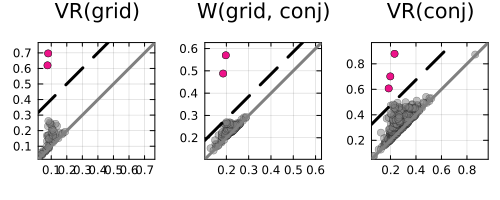

In [9]:
# plot persistence diagrams
p1 = plot_PD(barcode_VR_grid, title = "VR(grid)", highlight = grid_idx, cutoff = grid_cutoff)
p2 = plot_PD(barcode_W_grid_conj, title = "W(grid, conj)", highlight = W_idx, cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "VR(conj)", highlight = conj_idx, cutoff = conj_cutoff)
plot(p1, p2, p3, layout = grid(1,3), size = (500, 200))

# 3. Run baseline similarity-centric analogous bars


In [17]:
selected = W_idx

2-element Vector{Int64}:
 136
 137

In [ ]:
analogous_grid, analogous_conj = analogous_bars.run_baseline_similarity_analogous(VR_P = VR_grid,
                                                                    D_P = D_grid,
                                                                    VR_Q = VR_conj,
                                                                    D_Q = D_conj,
                                                                    W_PQ = W_grid_conj,
                                                                    W_PQ_bars = selected,
                                                                    dim = 1);

## Plot analogous pairs

### Analogous pair via witness bar 136

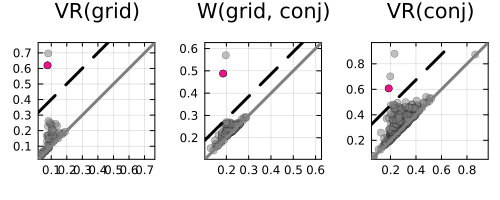

In [23]:
# plot persistence diagrams
witness_bar = 136
p1 = plot_PD(barcode_VR_grid, title = "VR(grid)", highlight = analogous_grid[witness_bar]["baseline_bar_extension"], cutoff = grid_cutoff)
p2 = plot_PD(barcode_W_grid_conj, title = "W(grid, conj)", highlight = [witness_bar], cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "VR(conj)", highlight = analogous_conj[witness_bar]["baseline_bar_extension"], cutoff = conj_cutoff)
plot(p1, p2, p3, layout = grid(1,3), size = (500, 200))

### Analogous pair via Witness bar 137

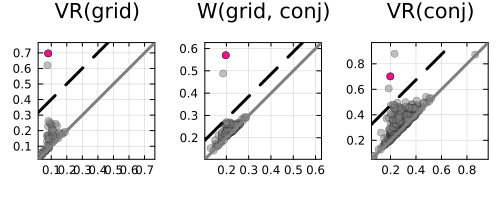

In [24]:
# plot persistence diagrams
witness_bar = 137
p1 = plot_PD(barcode_VR_grid, title = "VR(grid)", highlight = analogous_grid[witness_bar]["baseline_bar_extension"], cutoff = grid_cutoff)
p2 = plot_PD(barcode_W_grid_conj, title = "W(grid, conj)", highlight = [witness_bar], cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "VR(conj)", highlight = analogous_conj[witness_bar]["baseline_bar_extension"], cutoff = conj_cutoff)
plot(p1, p2, p3, layout = grid(1,3), size = (500, 200))

In [53]:
# gather barcodes
barcodes = Dict()
barcodes["VR_grid"] = barcode_VR_grid
barcodes["VR_conj"] = barcode_VR_conj
barcodes["W_grid_conj"] = barcode_W_grid_conj

# gather the persistence cutoff and selected bars
persistence_cutoff = Dict()
persistence_cutoff["grid_selected"] = grid_idx
persistence_cutoff["grid_cutoff"] = grid_cutoff
persistence_cutoff["conj_selected"] = conj_idx
persistence_cutoff["conj_cutoff"] = conj_cutoff
persistence_cutoff["W_grid_conj_selected"] = W_idx
persistence_cutoff["W_grid_conj_cutoff"] = W_cutoff;

# gather analogous pairs
analogous_pair = Dict()

for i in selected
    pair_i = Dict()
    pair_i["order"] = ["grid", "conjunctive"]
    pair_i["baseline_bar_ext"] = [analogous_grid[i]["baseline_bar_extension"], analogous_conj[i]["baseline_bar_extension"]]
    pair_i["epsilon_0"] = [analogous_grid[i]["epsilon_0"], analogous_conj[i]["epsilon_0"]]
    pair_i["min_epsilon_with_boundary"] = [analogous_grid[i]["min_epsilon_with_boundary"], analogous_conj[i]["min_epsilon_with_boundary"]]
    analogous_pair[i] = pair_i
end

# save output
"""
save("simulated_data/grid_conj_analogous_outputs.jld2", 
    "barcodes", barcodes,
    "persistence_cutoff", persistence_cutoff,
    "analogous_pair", analogous_pair)
"""


In [57]:
# save Witness persistence info
"""
save("simulated_data/grid_conj_W_persistence.jld2", 
   "eirene_output", W_grid_conj["eirene_output"],
    "index2simplex", W_grid_conj["index2simplex"],
    "W_vertex_to_defualt_vertex", W_grid_conj["W_vertex_to_default_vertex"])

save("simulated_data/conj_grid_W_persistence.jld2", 
    "eirene_output", W_conj_grid["eirene_output"],
    "index2simplex", W_conj_grid["index2simplex"],
    "W_vertex_to_defualt_vertex", W_conj_grid["W_vertex_to_default_vertex"])
"""

# 4. Run baseline similarity-centric analogous bars from Witness birthtime

In [10]:
W_idx

2-element Vector{Int64}:
 136
 137

In [17]:
@time extension_P_136, extension_Q_136 = run_baseline_similarity_analogous_birthtime_fast(
                                            VR_P = VR_grid,
                                            D_P = D_grid,
                                            VR_Q = VR_conj,
                                            D_Q = D_conj,
                                            W_PQ = W_grid_conj,
                                            W_PQ_bar = 136
                                            );

extension to P complete
computed Dowker dual
extension to Q complete
 82.161300 seconds (662.27 M allocations: 152.593 GiB, 6.64% gc time, 0.19% compilation time)


In [38]:
grid_136 = [i for i in extension_P_136["baseline_bar_extension"] if i in grid_idx]
conj_136 = [i for i in extension_Q_136["baseline_bar_extension"] if i in conj_idx];

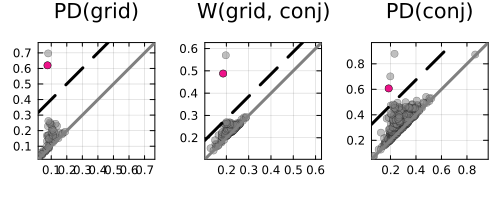

In [39]:
# plot persistence diagrams
witness_bar = 136
p1 = plot_PD(barcode_VR_grid, title = "PD(grid)", highlight = grid_136, cutoff = grid_cutoff)
p2 = plot_PD(barcode_W_grid_conj, title = "W(grid, conj)", highlight = [witness_bar], cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "PD(conj)", highlight = conj_136, cutoff = conj_cutoff)
plot(p1, p2, p3, layout = grid(1,3), size = (500, 200))

In [21]:
@time extension_P_137, extension_Q_137 = run_baseline_similarity_analogous_birthtime_fast(
                                            VR_P = VR_grid,
                                            D_P = D_grid,
                                            VR_Q = VR_conj,
                                            D_Q = D_conj,
                                            W_PQ = W_grid_conj,
                                            W_PQ_bar = 137
                                            );

extension to P complete
computed Dowker dual
extension to Q complete
1307.071576 seconds (11.98 G allocations: 2.907 TiB, 25.05% gc time, 0.00% compilation time)


In [40]:
# select analogous cycles that are significant
grid_137 = [i for i in extension_P_137["baseline_bar_extension"] if i in grid_idx]
conj_137 = [i for i in extension_Q_137["baseline_bar_extension"] if i in conj_idx];

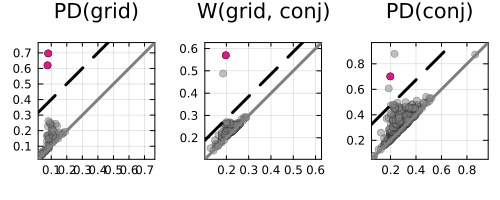

In [41]:
# plot persistence diagrams
witness_bar = 137
p1 = plot_PD(barcode_VR_grid, title = "PD(grid)", highlight = grid_137, cutoff = grid_cutoff)
p2 = plot_PD(barcode_W_grid_conj, title = "W(grid, conj)", highlight = [witness_bar], cutoff = W_cutoff)
p3 = plot_PD(barcode_VR_conj, title = "PD(conj)", highlight = conj_137, cutoff = conj_cutoff)
plot(p1, p2, p3, layout = grid(1,3), size = (500, 200))

# Save

In [32]:
# save barcodes
directory = "birthtime_analogous_outputs/"
# writedlm(directory * "barcode_grid.csv",  barcode_VR_grid, ',')
# writedlm(directory * "barcode_conj.csv",  barcode_VR_conj, ',')
# writedlm(directory * "barcode_W_grid_conj.csv", barcode_W_grid_conj, ',')

In [33]:
# save all significant points and threshold
# save(directory * "significant_PD.jld2", 
#     "grid_selected", grid_idx,
#     "grid_cutoff", grid_cutoff,
#     "conj_selected", conj_idx,
#     "conj_cutoff", conj_cutoff,
#     "W_grid_conj_selected", W_idx,
#     "W_grid_conj_cutoff", W_cutoff)

In [42]:
# save analogous pairs
# save(directory * "analogous_via_136.jld2",
#     "analogous_grid", extension_P_136["baseline_bar_extension"],
#     "analogous_conj", extension_Q_136["baseline_bar_extension"],
#     "analogous_grid_significant", grid_136,
#     "analogous_conj_significant", conj_136)

# save(directory * "analogous_via_137.jld2",
#     "analogous_grid", extension_P_137["baseline_bar_extension"],
#     "analogous_conj", extension_Q_137["baseline_bar_extension"],
#     "analogous_grid_significant", grid_137,
#     "analogous_conj_significant", conj_137)

In [43]:
analogous_136 = load(directory * "analogous_via_136.jld2")

Dict{String, Any} with 4 entries:
  "analogous_conj"             => [431, 436, 315]
  "analogous_grid_significant" => [58]
  "analogous_conj_significant" => [436]
  "analogous_grid"             => [58]

In [44]:
analogous_137 = load(directory * "analogous_via_137.jld2")

Dict{String, Any} with 4 entries:
  "analogous_conj"             => [413, 422, 431, 437, 397]
  "analogous_grid_significant" => [59, 58]
  "analogous_conj_significant" => [437]
  "analogous_grid"             => [59, 58, 42]